# FEDERATED LEARNING

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadr
import numpy as np

# Collect data

Dataset documentation : "https://cas.uqam.ca/pub/web/CASdatasets-manual.pdf"

Here, we concentrate on 3 different datasets on Motor Insurers : 
- `freMPL` (*French Motor Personal Line datasets*): This collection of ten datasets comes from a private motor French insurer. Each dataset includes risk features, claim amount and claim history of around 30,000 policies for year 2004. We decided to concacenate the differents freMPL datasets to focus on statistics.
- `beMTPL16` (*Belgian motor third-part liability dataset*): The dataset beMTPL was collected by an unknown Belgium insurer. It consists of 70 791 claims for private motor insurance.
- `euMTPL` (*European motor TPL insurance*): The euMTPL compiles three years of experience from a European MTPL (Motor Third Party Liability) portfolio, including frequency and severity values for different types of losses. The data was collected during the first decade of the 21st century.

In [28]:
# Change the paths to the location of the data on your machine
fre_path="/Users/nayelbenabdesadok/GitProjects/Federated_Learning_Milliman/data_comparaison/freMPL.csv"
be_path="/Users/nayelbenabdesadok/GitProjects/Federated_Learning_Milliman/data_comparaison/beMTPL97.rda"
eu_path="/Users/nayelbenabdesadok/GitProjects/Federated_Learning_Milliman/data_comparaison/euMTPL.rda"
file_paths = [be_path, eu_path]

In [29]:
def load_rda(file_paths):
  dataframes = {}
  for file_path in file_paths:
      result = pyreadr.read_r(file_path)
      for key in result.keys():
          dataframes[key] = result[key]
  return dataframes

In [30]:
df_fre=pd.read_csv(fre_path)

In [31]:
df_0 = load_rda(file_paths)
dataframes = {
    "French": df_fre,
    "Belgium": df_0["beMTPL97"],
    "European": df_0["euMTPL"]
}

In [32]:
dataframes["European"]["vehicle_use"].value_counts()

vehicle_use
1     2359462
0       12670
5         518
26        402
4         145
Name: count, dtype: int64

In [33]:
print("French columns:", dataframes["French"].columns)
print("Belgium columns:", dataframes["Belgium"].columns)
print("European columns:", dataframes["European"].columns)


French columns: Index(['Exposure', 'LicAge', 'RecordBeg', 'Gender', 'MariStat', 'SocioCateg',
       'VehUsage', 'DrivAge', 'HasKmLimit', 'BonusMalus', 'ClaimAmount',
       'ClaimInd'],
      dtype='object')
Belgium columns: Index(['id', 'expo', 'claim', 'nclaims', 'amount', 'average', 'coverage',
       'ageph', 'sex', 'bm', 'power', 'agec', 'fuel', 'use', 'fleet',
       'postcode', 'long', 'lat'],
      dtype='object')
European columns: Index(['policy_id', 'group', 'fuel_type', 'year', 'vehicle_category',
       'vehicle_use', 'province', 'horsepower', 'gender', 'age', 'exposure',
       'cost_nc', 'num_nc', 'cost_cg', 'num_cg', 'cost_fcg', 'num_fcg',
       'cost_cd', 'num_cd'],
      dtype='object')


In [34]:
print("French columns:", np.shape(dataframes["French"]))
print("be columns:", np.shape(dataframes["Belgium"]))
print("eu columns:", np.shape(dataframes["European"]))


French columns: (243065, 12)
be columns: (163212, 18)
eu columns: (2373197, 19)


In [35]:
dataframes["European"]["cost_claim"] = dataframes["European"]["cost_nc"] + dataframes["European"]["cost_cg"] + dataframes["European"]["cost_fcg"] + dataframes["European"]["cost_cd"] 


In [36]:
dataframes["European"]["cost_claim"].describe()

count    2.373197e+06
mean     3.058943e+02
std      4.005364e+03
min     -1.034309e+04
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.452709e+06
Name: cost_claim, dtype: float64

# Choice of the variables to compare & Data Cleaning

Since the datasets are not identical, we need to select a common variable that will serve as the basis for comparison.
The target target variables are : 
- `Exposure` (*French :*`Exposure`, *Belgium :*`expo`, *European :*`exposure`): a numeric time of exposure, from 0 (no exposure) to 1 (exposure during 1 year). -- **real number in [0,1]**
- `DriverAge` (*French :*`DrivAge`, *Belgium :*`ageph`, *European :*`age`): age of the driver -- **integer**
- `Gender` (*French :*`Gender`, *Belgium :*`sex`, *European :*`gender`): gender of the driver -- **{Male: 0,Female: 1}**
- `VehiculeUsage` (*French :*`VehUsage`, *Belgium :*`use`, *European :*`vehicle_use`): age of the driver -- **integer**
- `ClaimAmout` (*French :*`ClaimAmount`, *Belgium :*``, *European :*`cost_...`(differnt variables)):Total claim amount of the guarantee -- **real number**. For the european dataset, We will sum all the different `cost`variables to agregate all the sinisters.

Since the datasets have different variables, it is challenging to compare them accurately. Moreover, the French database had to be concatenated, and some variables had to be removed, for example.

In [37]:
french_data = dataframes["French"].rename(columns={
    'Exposure': 'Exposure',
    'DrivAge': 'DriverAge',
    'Gender': 'Gender',
    'VehUsage': 'VehiculeUsage',
    'ClaimAmount': 'ClaimAmount'
})[['Exposure', 'DriverAge', 'Gender', 'VehiculeUsage', 'ClaimAmount']]

belgium_data = dataframes["Belgium"].rename(columns={
    'expo': 'Exposure',
    'ageph': 'DriverAge',
    'sex': 'Gender',
    'use': 'VehiculeUsage',
    'amount': 'ClaimAmount'
})[['Exposure', 'DriverAge', 'Gender', 'VehiculeUsage', 'ClaimAmount']]

european_data = dataframes["European"].rename(columns={
    'exposure': 'Exposure',
    'age': 'DriverAge',
    'gender': 'Gender',
    'vehicle_use': 'VehiculeUsage',
    'cost_claim': 'ClaimAmount'
})[['Exposure', 'DriverAge', 'Gender', 'VehiculeUsage', 'ClaimAmount']]



french_data['Sinistre'] = (french_data['ClaimAmount'] > 0).astype(int)
belgium_data['Sinistre'] = (belgium_data['ClaimAmount'] > 0).astype(int)
european_data['Sinistre'] = (european_data['ClaimAmount'] > 0).astype(int)


french_data['Gender'] = french_data['Gender'].replace({'Female': 1, 'Male': 0})
belgium_data['Gender'] = belgium_data['Gender'].replace({'female': 1, 'male': 0})
european_data['Gender'] = european_data['Gender'].replace({'F': 1, 'M': 0})



/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_29884/1479271019.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  french_data['Gender'] = french_data['Gender'].replace({'Female': 1, 'Male': 0})
/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_29884/1479271019.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  belgium_data['Gender'] = belgium_data['Gender'].replace({'female': 1, 'male': 0})
/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_29884/1479271019.py:33: FutureWarning: The behavior of Se

In [38]:
print("BELGIUM : ",belgium_data["VehiculeUsage"].value_counts(),'\n')
print("FRANCE ",french_data["VehiculeUsage"].value_counts(),'\n')
print("EUROPE : ",european_data["VehiculeUsage"].value_counts(),'\n')

BELGIUM :  VehiculeUsage
private    155334
work         7878
Name: count, dtype: int64 

FRANCE  VehiculeUsage
Private+trip to office    119201
Private                    81582
Professional               38003
Professional run            4279
Name: count, dtype: int64 

EUROPE :  VehiculeUsage
1     2359462
0       12670
5         518
26        402
4         145
Name: count, dtype: int64 



### Sample the European data to approximize the size of the French and Belgium data

In [39]:
reduction_factor = 10
sample_size = len(european_data) // reduction_factor
european_data = european_data.sample(sample_size)

french_size = len(french_data)
belgium_size = len(belgium_data)
european_size = len(european_data)

total_size = french_size + belgium_size + european_size

french_proportion = 100 * (french_size / total_size)
belgium_proportion = 100 * (belgium_size / total_size)
european_proportion = 100 * (european_size / total_size)

print("French Proportion :", round(french_proportion, 2), "%")
print("Belgium Proportion :", round(belgium_proportion, 2), "%")
print("European Proportion :", round(european_proportion, 2), "%")


French Proportion : 37.77 %
Belgium Proportion : 25.36 %
European Proportion : 36.87 %


In [40]:
french_data.drop(columns=['ClaimAmount'], inplace=True)
belgium_data.drop(columns=['ClaimAmount'], inplace=True)      
european_data.drop(columns=['ClaimAmount'], inplace=True)

In [41]:
french_data["VehiculeUsage"].value_counts()

french_data["VehiculeUsage"] = french_data["VehiculeUsage"].replace({'Private+trip to office': 1,
                                                                     'Private': 1,
                                                                     'Professional': 0,
                                                                     'Professional run': 0})

/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_29884/670419836.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  french_data["VehiculeUsage"] = french_data["VehiculeUsage"].replace({'Private+trip to office': 1,


In [42]:
belgium_data["VehiculeUsage"].value_counts()

belgium_data["VehiculeUsage"] = belgium_data["VehiculeUsage"].replace({'private': 1,
                                                                     'work': 0})

/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_29884/775176063.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  belgium_data["VehiculeUsage"] = belgium_data["VehiculeUsage"].replace({'private': 1,
/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_29884/775176063.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  belgium_data["VehiculeUsage"] = belgium_data["VehiculeUsage"].replace({'private': 1,


In [43]:
european_data["VehiculeUsage"].value_counts()
#european_data=european_data[european_data["VehiculeUsage"].isin([1,0])]

# 1: private, 0: professional

VehiculeUsage
1     236031
0       1197
5         44
26        34
4         13
Name: count, dtype: int64

In [44]:
french_data.to_csv("french_data.csv")
belgium_data.to_csv("belgium_data.csv")
european_data.to_csv("european_data.csv")

In [45]:

french_data['Dataset'] = 'french'
belgium_data['Dataset'] = 'belgium'
european_data['Dataset'] = 'european'

df_combined=pd.concat([french_data, belgium_data, european_data])
df_combined

,Exposure,DriverAge,Gender,VehiculeUsage,Sinistre,Dataset
0,0.583000,55,1,0,0,french
1,0.200000,34,0,1,0,french
2,0.083000,33,1,0,0,french
3,0.375000,34,1,0,0,french
4,0.500000,53,0,0,1,french
...,...,...,...,...,...,...
3422,1.000000,66,0,1,0,european
1288786,0.994536,66,0,1,0,european
37514,0.057534,62,0,1,0,european
1805646,0.219178,31,1,1,0,european


### Sinistre par dataset

In [46]:
df_claim = df_combined.groupby(['Dataset', 'Sinistre']).size().reset_index(name='Count')
df_claim['Proportion'] = df_claim.groupby('Dataset')['Count'].transform(lambda x: x / x.sum())

/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_29884/1239152887.py:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(data=df_claim, x='Dataset', y='Proportion', hue='Sinistre', palette=palette, edgecolor='.3', linewidth=.8)


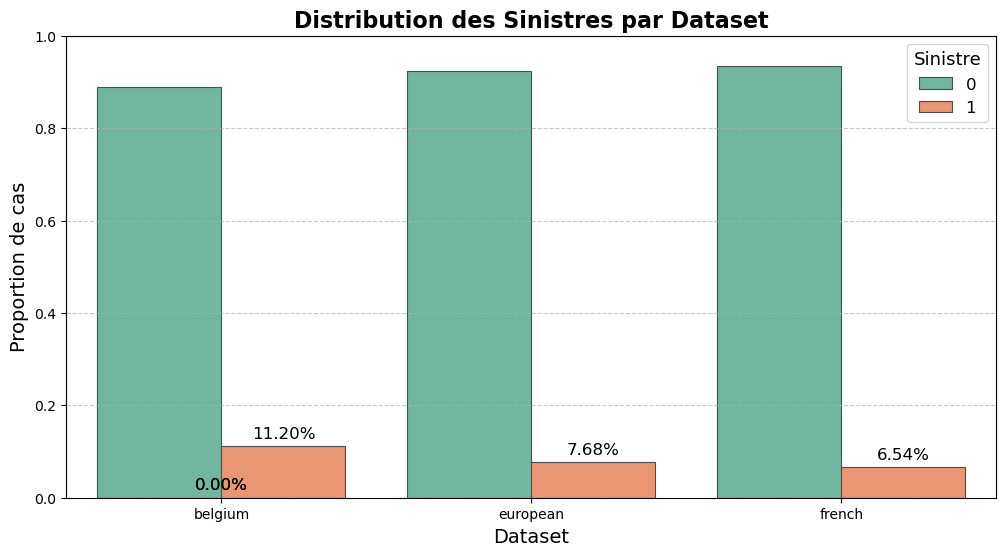

In [47]:
palette = sns.color_palette("Set2")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_claim, x='Dataset', y='Proportion', hue='Sinistre', palette=palette, edgecolor='.3', linewidth=.8)
plt.title('Distribution des Sinistres par Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Proportion de cas', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2%}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 9),
                       textcoords='offset points',
                       fontsize=12,
                       color='white' if p.get_height() > 0.5 else 'black')

plt.legend(title='Sinistre', title_fontsize='13', fontsize='12', loc='upper right')

plt.show()

### Proportion de Sinistres par Âge du Conducteur (DriverAge)

/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_29884/2005202093.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.lineplot(data=df_age_proportions, x='DriverAge', y='Proportion', hue='Dataset', style='Sinistre', markers=True, palette=palette)


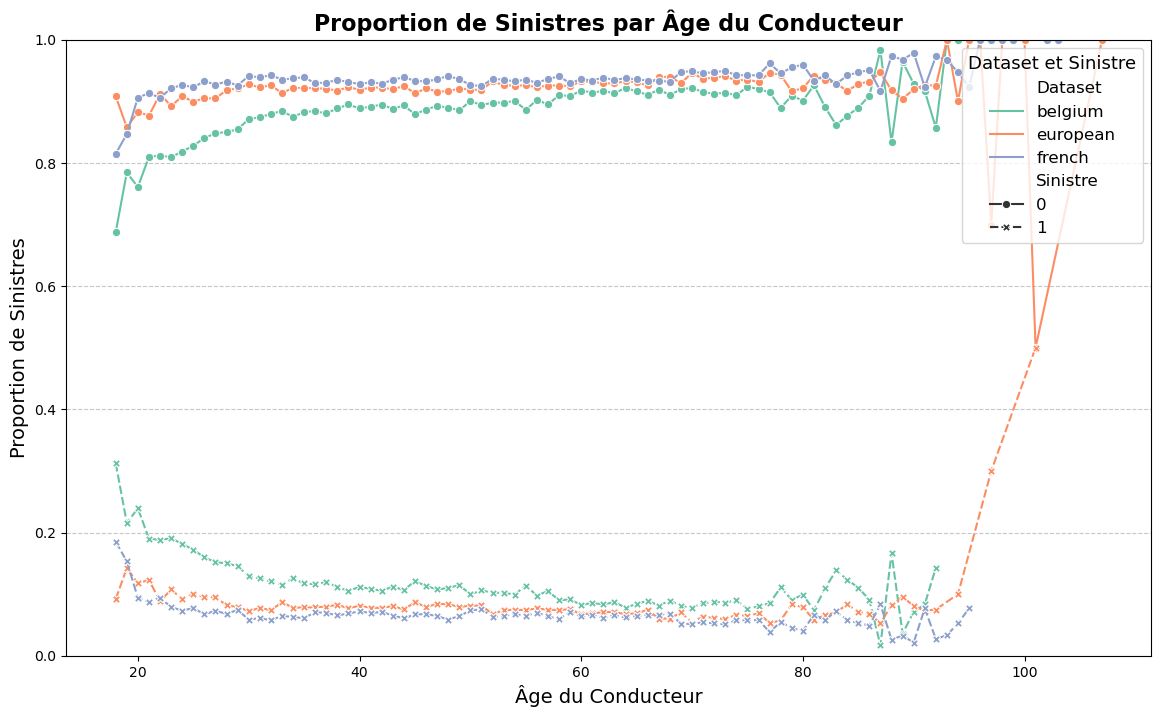

In [48]:
df_age_proportions = df_combined.groupby(['Dataset', 'DriverAge', 'Sinistre']).size().reset_index(name='Count')
df_age_proportions['Proportion'] = df_age_proportions.groupby(['Dataset', 'DriverAge'])['Count'].transform(lambda x: x / x.sum())

palette = sns.color_palette("Set2")

plt.figure(figsize=(14, 8))
sns.lineplot(data=df_age_proportions, x='DriverAge', y='Proportion', hue='Dataset', style='Sinistre', markers=True, palette=palette)
plt.title('Proportion de Sinistres par Âge du Conducteur', fontsize=16, fontweight='bold')
plt.xlabel('Âge du Conducteur', fontsize=14)
plt.ylabel('Proportion de Sinistres', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(title='Dataset et Sinistre', title_fontsize='13', fontsize='12', loc='upper right')

plt.show()

### Sinistres par Genre (Gender)

/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_29884/4101260678.py:9: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=df_gender_proportions, x='Gender', y='Proportion', hue='Dataset', palette=palette, edgecolor='.3', linewidth=.8)


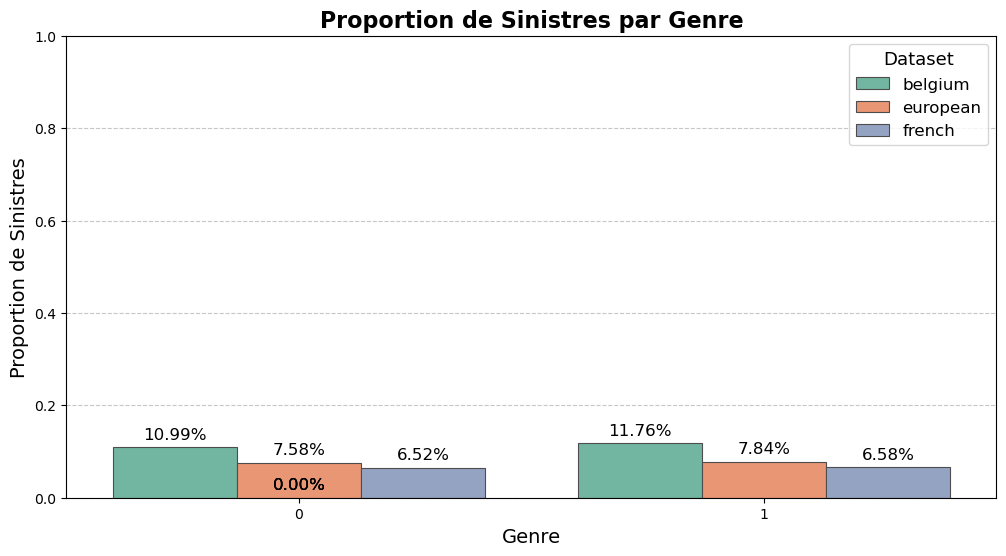

In [49]:
df_gender_proportions = df_combined.groupby(['Dataset', 'Gender', 'Sinistre']).size().reset_index(name='Count')
df_gender_proportions['Proportion'] = df_gender_proportions.groupby(['Dataset', 'Gender'])['Count'].transform(lambda x: x / x.sum())

df_gender_proportions = df_gender_proportions[df_gender_proportions['Sinistre'] == 1]

palette = sns.color_palette("Set2")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_gender_proportions, x='Gender', y='Proportion', hue='Dataset', palette=palette, edgecolor='.3', linewidth=.8)
plt.title('Proportion de Sinistres par Genre', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Proportion de Sinistres', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2%}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 9),
                       textcoords='offset points',
                       fontsize=12,
                       color='white' if p.get_height() > 0.5 else 'black')

plt.legend(title='Dataset', title_fontsize='13', fontsize='12', loc='upper right')

plt.show()

In [50]:
french_data["VehiculeUsage"]

0         0
1         1
2         0
3         0
4         0
         ..
243060    0
243061    1
243062    1
243063    1
243064    1
Name: VehiculeUsage, Length: 243065, dtype: int64

In [51]:
belgium_data.describe()

,Exposure,DriverAge,Sinistre
count,163212.000000,163212.000000,163212.000000
mean,0.889744,47.000950,0.111977
std,0.244202,14.831561,0.315339
min,0.002740,18.000000,0.000000
25%,1.000000,35.000000,0.000000
50%,1.000000,46.000000,0.000000
75%,1.000000,58.000000,0.000000
max,1.000000,95.000000,1.000000


In [52]:
# Calculer la distribution des âges par base de données
age_distribution = df_combined.groupby(['Dataset', 'AgeBin']).size().reset_index(name='Count')
total_by_dataset = age_distribution.groupby('Dataset')['Count'].sum().reset_index()
age_distribution = age_distribution.merge(total_by_dataset, on='Dataset')
age_distribution['Proportion'] = age_distribution['Count_x'] / age_distribution['Count_y'] * 100

# Pivoter pour avoir un format adapté au tableau
distribution_pivot = pd.pivot_table(
    age_distribution,
    values='Proportion',
    index='AgeBin',
    columns='Dataset'
)

# Formater en pourcentage avec 2 décimales
distribution_pivot = distribution_pivot.applymap(lambda x: f"{x:.2f}%")

# Renommer les colonnes
if 'french' in distribution_pivot.columns and 'belgium' in distribution_pivot.columns and 'european' in distribution_pivot.columns:
    distribution_pivot.columns = ['France', 'Belgique', 'Europe']

# Afficher le tableau formaté pour LaTeX
print(distribution_pivot.to_latex())

KeyError: 'AgeBin'

In [36]:
proportion_pivot

,France,Belgique,Europe
AgeBin,,,
15-19,15.94%,22.73%,12.05%
20-24,8.19%,19.02%,10.11%
25-29,7.17%,15.52%,8.63%
30-34,6.10%,12.32%,7.67%
35-39,6.71%,11.39%,7.71%
40-44,6.78%,10.89%,7.95%
45-49,6.44%,11.34%,8.24%
50-54,6.89%,10.20%,8.07%
55-59,6.58%,9.96%,7.70%


/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_22609/3582400607.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_counts = df_combined.groupby(['Dataset', 'AgeBin']).size().reset_index(name='Count')


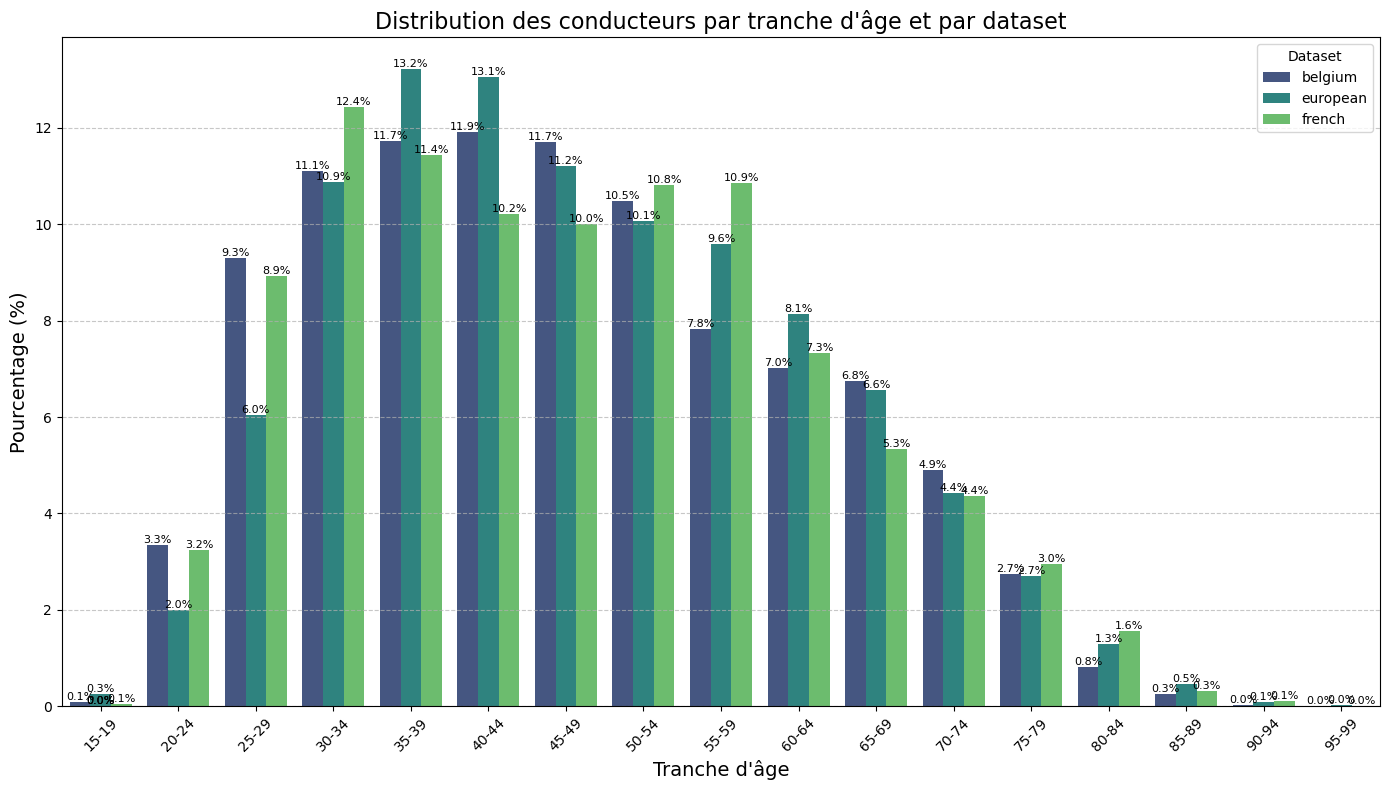

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Créer les tranches d'âge de 5 ans
df_combined['AgeBin'] = pd.cut(df_combined['DriverAge'], 
                              bins=range(15, 101, 5),
                              right=False,
                              labels=[f"{i}-{i+4}" for i in range(15, 96, 5)])

# Calculer la distribution des âges par dataset
age_counts = df_combined.groupby(['Dataset', 'AgeBin']).size().reset_index(name='Count')

# Calculer les pourcentages par dataset
total_by_dataset = age_counts.groupby('Dataset')['Count'].sum().reset_index()
age_counts = age_counts.merge(total_by_dataset, on='Dataset')
age_counts['Percentage'] = age_counts['Count_x'] / age_counts['Count_y'] * 100

# Créer l'histogramme
plt.figure(figsize=(14, 8))
sns.barplot(data=age_counts, x='AgeBin', y='Percentage', hue='Dataset', palette='viridis')

plt.title('Distribution des conducteurs par tranche d\'âge et par dataset', fontsize=16)
plt.xlabel('Tranche d\'âge', fontsize=14)
plt.ylabel('Pourcentage (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()

# Ajouter les valeurs sur les barres pour une meilleure lisibilité (optionnel)
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.1f}%", 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'bottom', 
                      fontsize=8)

plt.show()